<a href="https://colab.research.google.com/github/nkumeh/MusicInformationRetrieval/blob/main/bird_call_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import and Load Dependencies and Libraries

In [ ]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio

2023-10-22 01:56:32.881538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Build Data Loading Function

In [ ]:
# Defining paths to files

CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-0.wav')
NOT_CAPUCHIN_FILE = os.path.join('data','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-0.wav')

In [ ]:
CAPUCHIN_FILE

'data/Parsed_Capuchinbird_Clips/XC3776-0.wav'

In [ ]:
# data loading function from tensorflow documentation

def load_wav_16k_mono(filename):
    # load the encoded wav file and convert to waveform
    file_content = tf.io.read_file(filename) # this return a string not the audio yet

    # decode wav (tensors by channels)
    wav, sr = tf.audio.decode_wav(file_content, desired_channels=1) # mono channel not stereo for ease of analysis

    # remove trailing axis sr--> 44100HZ
    wav = tf.squeeze(wav, axis=-1)
    sr = tf.cast(sr, dtype = tf.int64)

    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)

    return wav

In [ ]:
# Plot wave
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

2023-10-22 01:56:37.954060: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 FMA


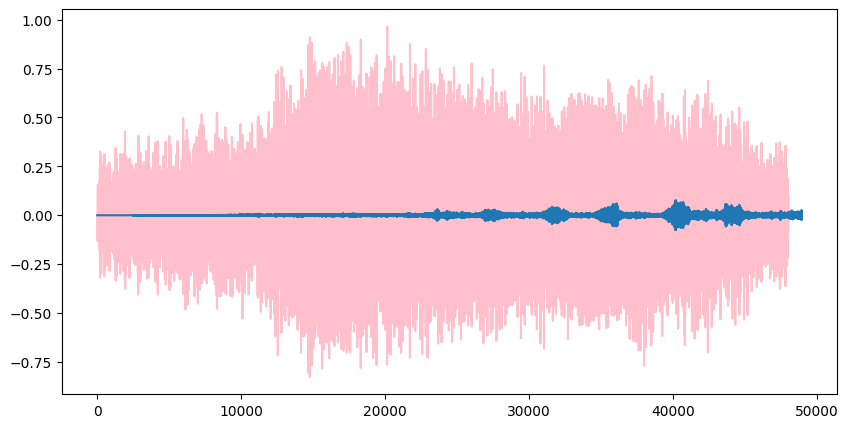

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(wave, color="pink")
plt.plot(nwave)

plt.show()

### Create Tensorflow Dataset

In [ ]:
# define global variables for posirive and negative data paths

POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [ ]:
# set of files as a string in tensorflow
# look for files in the .wav format
pos = tf.data.Dataset.list_files(POS + '/*.wav')
neg = tf.data.Dataset.list_files(NEG + '/*.wav')

In [ ]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC216010-5.wav'

In [ ]:
# add labels and combine pos and negative values
# adding same length of 1s for pos 0s for neg .... binary classification problem

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

# concatenate
data = positives.concatenate(negatives)

In [ ]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data/Parsed_Not_Capuchinbird_Clips/sparrow-sound-effect-18.wav', 0.0)

### Determine Average Length of Capuchin Call

In [ ]:
# calculate wave cycle length

lengths = []

for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
    # go through list of pos and apply
    lengths.append(len(tensor_wave))

In [ ]:
os.listdir(os.path.join(NEG))

### Let's get some Stats of the Capuchin Calls!

In [ ]:
54156/16000 #capuchin calls per sec

3.38475

In [ ]:
tf.math.reduce_mean(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

### Preprocessing and Convertion to Spectrogram: Short Term Fourier Transform

In [ ]:
# label used for forward / backward as part of the data pipeline, output at the end

def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]

    # for the clips that < 48000, we pad with zeros at the beginning(start)
    zero_padding_space = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding_space, wav], 0)

    # using the short term FT to convert to spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)

    # encapsulate spectrogram in appropriate dimentinality format for conv neral network, since it requires a channels dimention
    # liken to greyscale image in single channel
    spectrogram = tf.expand_dims(spectrogram, axis = 2)

    return spectrogram, label

In [ ]:
wav = load_wav_16k_mono(CAPUCHIN_FILE)
wav
wav = wav[:48000]

    # for the clips that < 48000, we pad with zeros at the beginning(start)
zero_padding_space = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
wav = tf.concat([zero_padding_space, wav], 0)

wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 1.0432389e-06, -3.0215922e-06,  1.9820709e-06, ...,
       -4.5542806e-02, -5.4887902e-02, -8.5778177e-02], dtype=float32)>

In [ ]:
spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
spectrogram = tf.abs(spectrogram)

# encapsulate spectrogram in appropriate format
spectrogram = tf.expand_dims(spectrogram, axis = 2)
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[1.9284576e-02],
        [2.5178067e-02],
        [2.9214473e-02],
        ...,
        [3.1451735e-04],
        [2.5453046e-04],
        [4.2855740e-05]],

       [[9.8426342e-03],
        [6.1191549e-03],
        [8.5132420e-03],
        ...,
        [4.6083337e-04],
        [2.3399896e-04],
        [2.1843612e-04]],

       [[1.1091478e-02],
        [6.1595612e-03],
        [8.8293683e-03],
        ...,
        [5.1367306e-04],
        [3.0327094e-04],
        [2.1337718e-04]],

       ...,

       [[6.3687041e-03],
        [7.4077337e-03],
        [1.7366953e-02],
        ...,
        [5.8575958e-04],
        [2.5817397e-04],
        [1.5325844e-05]],

       [[5.7284534e-03],
        [1.0320810e-02],
        [9.9355401e-03],
        ...,
        [6.0393481e-04],
        [2.4145524e-04],
        [8.3535910e-05]],

       [[4.4908077e-03],
        [4.3124957e-03],
        [1.3786455e-02],
        ...,
        [5.7142752

### Test out Function and Visualise Spectrogram

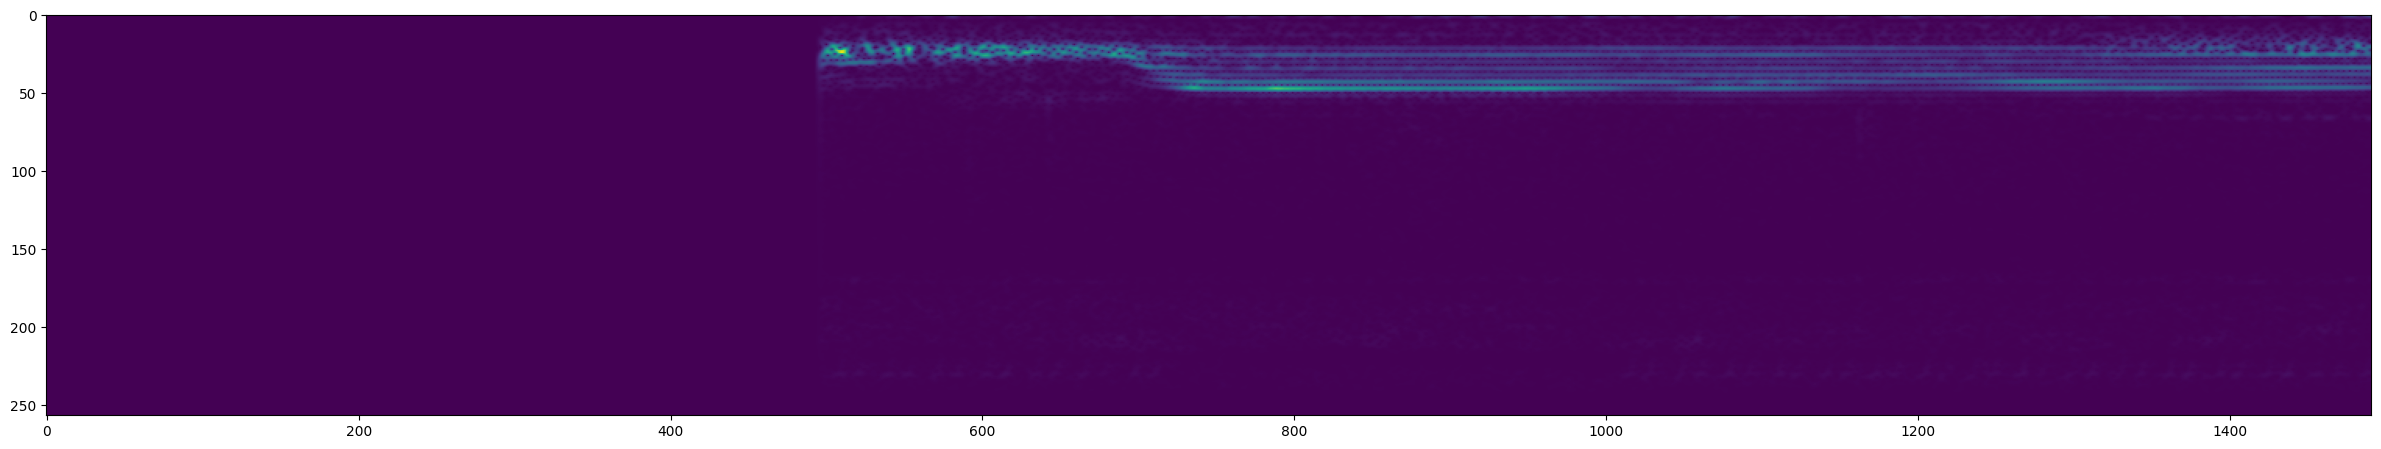

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(30,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       ...,

       [[1.97554111e+00],
        [1.57073951e+00],
        [7.37415254e-01],
        ...,
        [5.22490591e-05],
        [2.22928538e-05],
        [2.74181366e-05]],

       [[2.21417475e+00],
        [1.75383162e+00],
        [8.19831610e-01],
        ...,
        [1.41179125e-05],
        [5.40754736e-05],
        [2.14576721e-05]],

       [[2.39721632e+00],
        [1.89557064e+00],
        [8.71314168e-01]

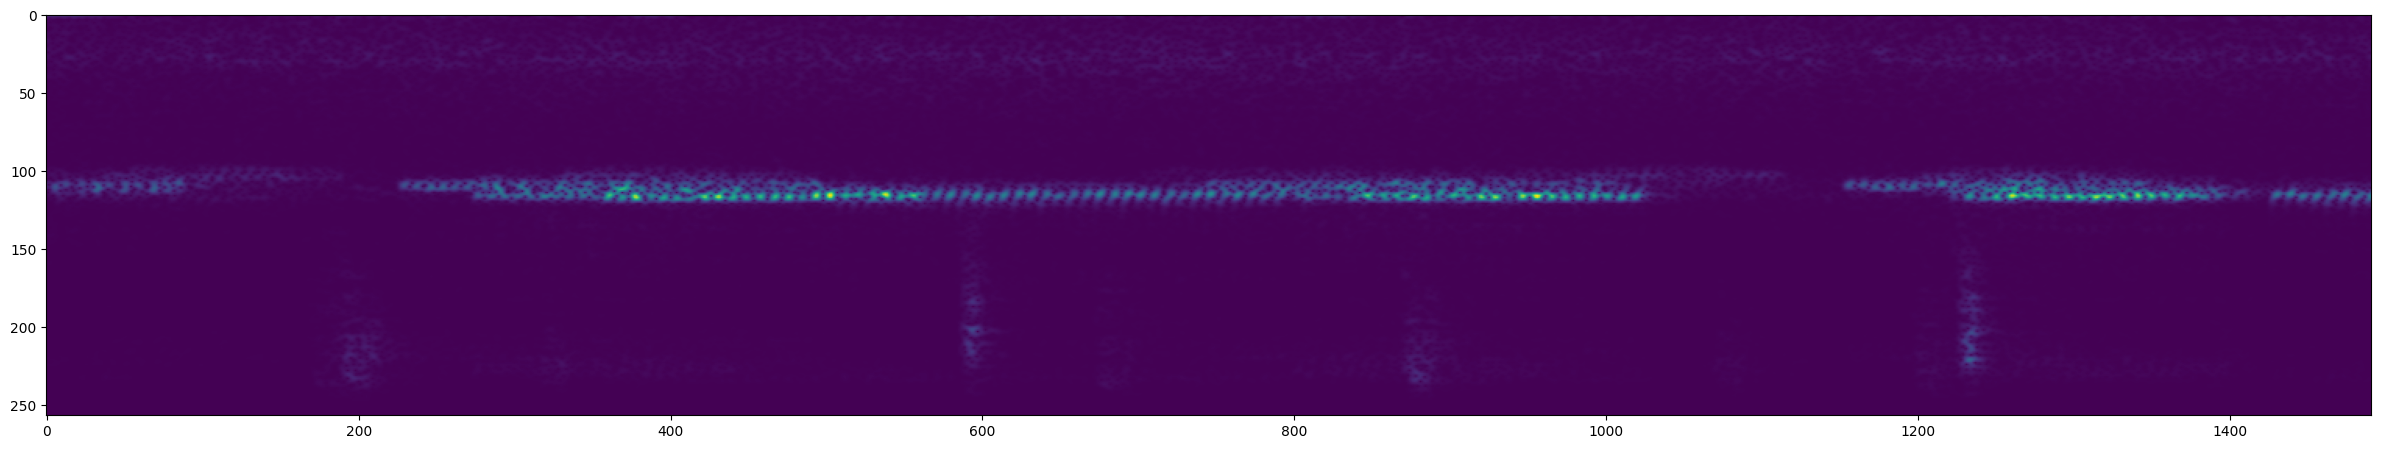

In [ ]:
filepath_n, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram_n, label = preprocess(filepath_n, label)
plt.figure(figsize=(30,10))
plt.imshow(tf.transpose(spectrogram_n)[0])
plt.show()

### Create a Train and Test Partition

In [ ]:
# MCSHUBAP
data = data.map(preprocess)
data = data.cache()
# shuffling to decrease overfitting / bias
data = data.shuffle(buffer_size=1000)
# smaples to take at a time
data = data.batch(16)
# eliminates any cpu bottlenecking
data = data.prefetch(8)

In [ ]:
len(data)*.7
# round up and take 36

35.699999999999996

In [ ]:
len(data)*.3

15.299999999999999

In [ ]:
# split into test and train

train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samp, label = test.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
samp.shape
# shape is foundation for input into model

(16, 1491, 257, 1)

In [ ]:
label.shape

(16,)

### Build Deep Learning Model

In [ ]:
# model apis

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
# build sequencial model

model = Sequential()
# input shape is tied to the shape of the spectrogram
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (2.87 GB)
Trainable params: 770482865 (2.87 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


In [ ]:
rec_1 = "/Users/kristineumeh/Desktop/projects/MIR/AudioSignalProcessing/DeepLearningTrials/audio_classification/data/Forest Recordings/recording_00.mp3"

In [ ]:
ipd.Audio(rec_1)

In [ ]:
rec, sr = librosa.load(rec_1)

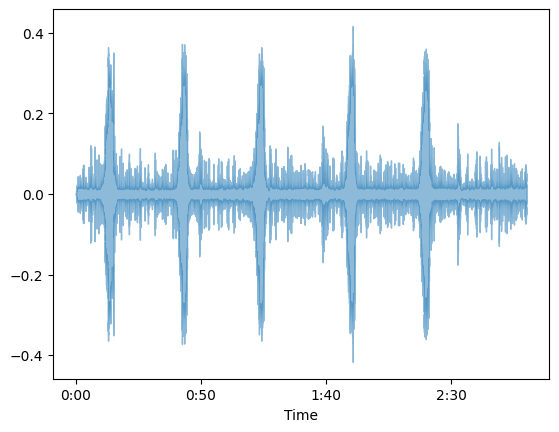

In [ ]:
librosa.display.waveshow(rec, alpha=0.5)